# MAIN
This is the master notebook for my AirBnB Recruiting Challenge work. Changes and additions are made by branching and merging.

Other possible branches:
* Explore
* Prepocessing
* Features
* Models
* Multiclass
* Imbalance
* Validation
* Ensembels


## Imports

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("whitegrid") #, {'ytick.major.size': 10.0})
#sns.set_context("talk")

In [266]:
# Load data into DataFrames
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')

## Preprocessing

In [267]:
def preprocess_missing(df):
    ##AGE
    #Remove all ages outside of range, set to -1 for separate categorisation //impute for logistic regression
    df.loc[df.age > 95, 'age'] = -1
    df.loc[df.age < 13, 'age'] = -1
    df.fillna(-1,inplace=True)

    ## GENDER
    # Set missing values to own category
    df['gender'].replace('-unknown-',np.nan, inplace=True)
    #df['gender'].fillna('MISSING',inplace=True)

    ## FIRST AFFILIATE TRACKED
    # Set missing to untracked, hopefully the same
    df['first_affiliate_tracked'].fillna('untracked',inplace=True)
    
    ## Get rid of date_first_booking
    df.drop(['id','date_first_booking'],axis=1,inplace=True)
    
    return df

def preprocess_features(df):
    ## dates
    
    # date_account_created
    dac = np.vstack(df.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
    df['dac_year'] = dac[:,0]
    df['dac_month'] = dac[:,1]
    df['dac_day'] = dac[:,2]
    df.drop(['date_account_created'],axis=1,inplace=True)
    
    #time first active
    tfa = np.vstack(df.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
    df['tfa_year'] = tfa[:,0]
    df['tfa_month'] = tfa[:,1]
    df['tfa_day'] = tfa[:,2]
    df['tfa_hour'] = tfa[:,3]
    df.drop(['timestamp_first_active'],axis=1,inplace=True)
    
    
    ## One-Hot Encoding
    categorical_features = ['affiliate_channel','affiliate_provider','first_affiliate_tracked',
                            'first_browser','first_device_type','gender','language','signup_app','signup_flow','signup_method'
                           ]
    
    df = pd.get_dummies(df,columns=categorical_features)
    
    return df

def preprocess_all(df):

    df_p = preprocess_missing(df)
    df_p = preprocess_features(df_p)
    
    return(df_p)

In [268]:
X_master = preprocess_all(train_users.drop(['country_destination'],axis=1))
y_master = train_users['country_destination']
train_master = pd.concat([X_master,y_master],axis=1)

## Classifiers

In [269]:
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn import metrics

### Logistic Regression
Logistic Regression without Grid Search on gets CrossVal of 0.657, which is a mild improvement over 0.583 for setting all NDF. Balancing classes brings it down negligably to 0.646
Grid search doesn't seemed to have helped - 0.658 with C of 11.94
After scaling age, this now appears third largest among the coefficients, though seemingly a decrease in accuracy to 0.63

Discretizing age has increased the score to 0.667, on 1% up. It's something.But none of the age variables features in important coefficients.
Reintoducing age as continuous (with NaNs imputed) together with discrete , brings things now up to 0.675. Huh

Interesting. The score on the training data is almost the same. So we might not be overfitting and just have too high bias.

And now the age brackets are appearing in the coeffs. How very strange. Seems that having entered your age validly correlates with actually booking. Now gender isn't showing up though. Could there just be the single latent variable of "filling out the form properly?"

Next run of GridSearch gives ~5 for C, stronger regularisation, and a score of 0.688, which is several points up from when I started.


In [271]:
## Customise Train and Test for Logistic Regression


## DISCRETIZE
X_log = X_master # Create X just for Logistic Regression
A = pd.cut(X_log['age'],list(range(14,100,5)),right=True)
A = pd.get_dummies(A)
X_log= pd.concat([X_log,A],axis=1)
#X_train.drop(['age'],axis=1,inplace=True)


## IMPUTE VALUES

X_log['age'].replace(-1,np.median(X['age']),inplace=True)
scaler = preprocessing.MinMaxScaler()
X_log['age'] = scaler.fit_transform(X_log['age'])


# Try Binary Problem First
y_log = y!='NDF'

c:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [272]:
from sklearn.linear_model import LogisticRegression

In [273]:
clf = LogisticRegression(C=4.5)

X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('Accuracy = ',metrics.accuracy_score(y_test,y_pred))
print('Recall = ',metrics.recall_score(y_test,y_pred))
print('Precision = ',metrics.precision_score(y_test,y_pred))

Accuracy =  0.689934973671
Recall =  0.523649873142
Precision =  0.657077885162


In [274]:
## Test for overfitting:
y_pred = clf.predict(X_train)
print('Accuracy = ',metrics.accuracy_score(y_train,y_pred))
print('Recall = ',metrics.recall_score(y_train,y_pred))
print('Precision = ',metrics.precision_score(y_train,y_pred))

Accuracy =  0.689564489531
Recall =  0.524687294273
Precision =  0.661697831953


### Cross Validate

In [278]:
print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))

JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
c:\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
c:\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000000000DDCAE0, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'c:\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000000000DDCAE0, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'c:\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
c:\Anaconda3\lib\site-packages\ipykernel\__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
c:\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    587         
    588         If a global instance already exists, this reinitializes and starts it
    589         """
    590         app = cls.instance(**kwargs)
    591         app.initialize(argv)
--> 592         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    593 
    594 #-----------------------------------------------------------------------------
    595 # utility functions, for convenience
    596 #-----------------------------------------------------------------------------

...........................................................................
c:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    398         
    399         if self.poller is not None:
    400             self.poller.start()
    401         self.kernel.start()
    402         try:
--> 403             ioloop.IOLoop.instance().start()
    404         except KeyboardInterrupt:
    405             pass
    406 
    407 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
c:\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
c:\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
c:\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
c:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
c:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
c:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
c:\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
c:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
c:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-01-01T16:07:50.242016', 'msg_id': 'AD47806CC28E4DBF8B1D66A2AC0FD1E0', 'msg_type': 'execute_request', 'session': 'DF1B7EDFFF5D42DDAE44D2F6ABCF8D76', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'AD47806CC28E4DBF8B1D66A2AC0FD1E0', 'msg_type': 'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'DF1B7EDFFF5D42DDAE44D2F6ABCF8D76']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-01-01T16:07:50.242016', 'msg_id': 'AD47806CC28E4DBF8B1D66A2AC0FD1E0', 'msg_type': 'execute_request', 'session': 'DF1B7EDFFF5D42DDAE44D2F6ABCF8D76', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'AD47806CC28E4DBF8B1D66A2AC0FD1E0', 'msg_type': 'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
c:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'DF1B7EDFFF5D42DDAE44D2F6ABCF8D76'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-01-01T16:07:50.242016', 'msg_id': 'AD47806CC28E4DBF8B1D66A2AC0FD1E0', 'msg_type': 'execute_request', 'session': 'DF1B7EDFFF5D42DDAE44D2F6ABCF8D76', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'AD47806CC28E4DBF8B1D66A2AC0FD1E0', 'msg_type': 'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
c:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))'
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
c:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))', store_history=True, silent=False, shell_futures=True)
   2897                 self.displayhook.exec_result = result
   2898 
   2899                 # Execute the user code
   2900                 interactivity = "none" if silent else self.ast_node_interactivity
   2901                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2902                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2903 
   2904                 # Reset this so later displayed values do not modify the
   2905                 # ExecutionResult
   2906                 self.displayhook.exec_result = None

...........................................................................
c:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-278-1e6124c34876>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3007                     return True
   3008 
   3009             for i, node in enumerate(to_run_interactive):
   3010                 mod = ast.Interactive([node])
   3011                 code = compiler(mod, cell_name, "single")
-> 3012                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000000035934AE0, file "<ipython-input-278-1e6124c34876>", line 1>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   3013                     return True
   3014 
   3015             # Flush softspace
   3016             if softspace(sys.stdout, 0):

...........................................................................
c:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000000035934AE0, file "<ipython-input-278-1e6124c34876>", line 1>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3061         outflag = 1  # happens in more places, so it's easier as default
   3062         try:
   3063             try:
   3064                 self.hooks.pre_run_code_hook()
   3065                 #rprint('Running code', repr(code_obj)) # dbg
-> 3066                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000000035934AE0, file "<ipython-input-278-1e6124c34876>", line 1>
        self.user_global_ns = {'A':         (14, 19]  (19, 24]  (24, 29]  (29, 34]  ...        0         0  

[213451 rows x 17 columns], 'B': array([15, 19, 24]), 'Crange': array([   0.1       ,    0.1268961 ,    0.161026...2.10169419,
         78.80462816,  100.        ]), 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'FeatureImportances': tfa_hour                              1.493423e-...ora                   0.000000e+00
dtype: float64, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', 'from sklearn import linear_model.LogisticRegression', 'from sklearn.linear_model import LogisticRegression', '# Try Binary Problem First\ny', 'import numpy as np\nimport pandas as pd\nimport ma...ytick.major.size\': 10.0})\nsns.set_context("talk")', "# Load data into DataFrames\ntrain_users = pd.rea...\ntest_users = pd.read_csv('input/test_users.csv')", 'def preprocess_missing(df):\n    ##AGE\n    #Remov...= preprocess_features(df_p)\n    \n    return(df_p)', "X = preprocess_all(train_users.drop(['country_de...],axis=1))\ny = train_users['country_destination']", '# Try Binary Problem First\ny', "# Try Binary Problem First\ny_train = y!='NDF'\ny_train", 'from sklearn.linear_model import LogisticRegression', "print cross_val_score(LogistictRegression(),X,y_train,cv=5,scoring='accuracy')", "print(cross_val_score(LogistictRegression(),X,y_train,cv=5,scoring='accuracy'))", 'from sklearn.cross_validation import cross_val_score', "print(cross_val_score(LogistictRegression(),X,y_train,cv=5,scoring='accuracy'))", "print(cross_val_score(LogisticRegression(),X,y_train,cv=5,scoring='accuracy'))", 'sum(y_train)/y_train.size[0]', 'sum(y_train)/y_train.size', "print(np.mean(cross_val_score(LogisticRegression(),X,y_train,cv=5,scoring='accuracy')))", 'sum(!y_train)/y_train.size', ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {8: 0           NDF
1           NDF
2            US
...     NDF
Name: country_destination, dtype: object, 9: 0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, 17: 0.4165265095970504, 20: 0.5834734904029496, 27: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 28: {'C': 11.937766417144358}, 29: 0.65801518849759433, 30: LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), 33: <bound method LogisticRegression.predict_proba o...l=0.0001,
          verbose=0, warm_start=False)>, 36: array([[ 0.82087433,  0.17912567],
       [ 0.47... 0.12081561],
       [ 0.82713043,  0.17286957]]), ...}, ...}
        self.user_ns = {'A':         (14, 19]  (19, 24]  (24, 29]  (29, 34]  ...        0         0  

[213451 rows x 17 columns], 'B': array([15, 19, 24]), 'Crange': array([   0.1       ,    0.1268961 ,    0.161026...2.10169419,
         78.80462816,  100.        ]), 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'FeatureImportances': tfa_hour                              1.493423e-...ora                   0.000000e+00
dtype: float64, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', 'from sklearn import linear_model.LogisticRegression', 'from sklearn.linear_model import LogisticRegression', '# Try Binary Problem First\ny', 'import numpy as np\nimport pandas as pd\nimport ma...ytick.major.size\': 10.0})\nsns.set_context("talk")', "# Load data into DataFrames\ntrain_users = pd.rea...\ntest_users = pd.read_csv('input/test_users.csv')", 'def preprocess_missing(df):\n    ##AGE\n    #Remov...= preprocess_features(df_p)\n    \n    return(df_p)', "X = preprocess_all(train_users.drop(['country_de...],axis=1))\ny = train_users['country_destination']", '# Try Binary Problem First\ny', "# Try Binary Problem First\ny_train = y!='NDF'\ny_train", 'from sklearn.linear_model import LogisticRegression', "print cross_val_score(LogistictRegression(),X,y_train,cv=5,scoring='accuracy')", "print(cross_val_score(LogistictRegression(),X,y_train,cv=5,scoring='accuracy'))", 'from sklearn.cross_validation import cross_val_score', "print(cross_val_score(LogistictRegression(),X,y_train,cv=5,scoring='accuracy'))", "print(cross_val_score(LogisticRegression(),X,y_train,cv=5,scoring='accuracy'))", 'sum(y_train)/y_train.size[0]', 'sum(y_train)/y_train.size', "print(np.mean(cross_val_score(LogisticRegression(),X,y_train,cv=5,scoring='accuracy')))", 'sum(!y_train)/y_train.size', ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {8: 0           NDF
1           NDF
2            US
...     NDF
Name: country_destination, dtype: object, 9: 0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, 17: 0.4165265095970504, 20: 0.5834734904029496, 27: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 28: {'C': 11.937766417144358}, 29: 0.65801518849759433, 30: LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), 33: <bound method LogisticRegression.predict_proba o...l=0.0001,
          verbose=0, warm_start=False)>, 36: array([[ 0.82087433,  0.17912567],
       [ 0.47... 0.12081561],
       [ 0.82713043,  0.17286957]]), ...}, ...}
   3067             finally:
   3068                 # Reset our crash handler in place
   3069                 sys.excepthook = old_excepthook
   3070         except SystemExit as e:

...........................................................................
c:\Users\RMB\Drive\Narutai\Project Files\Data Science\MySlideRule Intensive\Capstone\AirBnBKaggle\<ipython-input-278-1e6124c34876> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 print(np.mean(cross_val_score(clf,X_log,y_log,cv=10,n_jobs=3)))
      7 
      8 
      9 
     10 

...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py in cross_val_score(estimator=LogisticRegression(C=4.5, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), X=           age  dac_year  dac_month  dac_day  tf...       0         0  

[213451 rows x 172 columns], y=0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, scoring=None, cv=sklearn.cross_validation.StratifiedKFold(labels=...e], n_folds=10, shuffle=False, random_state=None), n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
   1428     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
   1429                         pre_dispatch=pre_dispatch)
   1430     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
   1431                                               train, test, verbose, None,
   1432                                               fit_params)
-> 1433                       for train, test in cv)
        cv = sklearn.cross_validation.StratifiedKFold(labels=...e], n_folds=10, shuffle=False, random_state=None)
   1434     return np.array(scores)[:, 0]
   1435 
   1436 
   1437 class FitFailedWarning(RuntimeWarning):

...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object cross_val_score.<locals>.<genexpr>>)
    807             if pre_dispatch == "all" or n_jobs == 1:
    808                 # The iterable was consumed all at once by the above for loop.
    809                 # No need to wait for async callbacks to trigger to
    810                 # consumption.
    811                 self._iterating = False
--> 812             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    813             # Make sure that we get a last message telling us we are done
    814             elapsed_time = time.time() - self._start_time
    815             self._print('Done %3i out of %3i | elapsed: %s finished',
    816                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Fri Jan  1 16:08:37 2016
PID: 3500                             Python 3.5.1: c:\Anaconda3\python.exe
...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (LogisticRegression(C=4.5, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False),            age  dac_year  dac_month  dac_day  tf...       0         0  

[213451 rows x 172 columns], 0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, <function _passthrough_scorer>, array([     0,      1,      2, ..., 213448, 213449, 213450]), array([56129, 56131, 56132, ..., 92090, 92091, 92092]), 0, None, None), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (LogisticRegression(C=4.5, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False),            age  dac_year  dac_month  dac_day  tf...       0         0  

[213451 rows x 172 columns], 0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, <function _passthrough_scorer>, array([     0,      1,      2, ..., 213448, 213449, 213450]), array([56129, 56131, 56132, ..., 92090, 92091, 92092]), 0, None, None)
        kwargs = {}
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py in _fit_and_score(estimator=LogisticRegression(C=4.5, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), X=           age  dac_year  dac_month  dac_day  tf...       0         0  

[213451 rows x 172 columns], y=0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, scorer=<function _passthrough_scorer>, train=array([     0,      1,      2, ..., 213448, 213449, 213450]), test=array([56129, 56131, 56132, ..., 92090, 92091, 92092]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, error_score='raise')
   1526 
   1527     try:
   1528         if y_train is None:
   1529             estimator.fit(X_train, **fit_params)
   1530         else:
-> 1531             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method LogisticRegression.fit of Logistic...l=0.0001,
          verbose=0, warm_start=False)>
        X_train =            age  dac_year  dac_month  dac_day  tf...       0         0  

[192106 rows x 172 columns]
        y_train = 0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool
        fit_params = {}
   1532 
   1533     except Exception as e:
   1534         if error_score == 'raise':
   1535             raise

...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py in fit(self=LogisticRegression(C=4.5, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), X=           age  dac_year  dac_month  dac_day  tf...       0         0  

[192106 rows x 172 columns], y=0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, sample_weight=None)
   1137         if not isinstance(self.tol, numbers.Number) or self.tol < 0:
   1138             raise ValueError("Tolerance for stopping criteria must be "
   1139                              "positive; got (tol=%r)" % self.tol)
   1140 
   1141         X, y = check_X_y(X, y, accept_sparse='csr', dtype=np.float64, 
-> 1142                          order="C")
   1143         check_classification_targets(y)
   1144         self.classes_ = np.unique(y)
   1145         n_samples, n_features = X.shape
   1146 

...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\utils\validation.py in check_X_y(X=           age  dac_year  dac_month  dac_day  tf...       0         0  

[192106 rows x 172 columns], y=0         False
1         False
2          True
...0    False
Name: country_destination, dtype: bool, accept_sparse='csr', dtype=<class 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    505     y_converted : object
    506         The converted and validated y.
    507     """
    508     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    509                     ensure_2d, allow_nd, ensure_min_samples,
--> 510                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    511     if multi_output:
    512         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    513                         dtype=None)
    514     else:

...........................................................................
c:\Anaconda3\lib\site-packages\sklearn\utils\validation.py in check_array(array=           age  dac_year  dac_month  dac_day  tf...       0         0  

[192106 rows x 172 columns], accept_sparse=['csr'], dtype=<class 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    368 
    369     if sp.issparse(array):
    370         array = _ensure_sparse_format(array, accept_sparse, dtype, copy,
    371                                       force_all_finite)
    372     else:
--> 373         array = np.array(array, dtype=dtype, order=order, copy=copy)
        array =            age  dac_year  dac_month  dac_day  tf...       0         0  

[192106 rows x 172 columns]
        dtype = <class 'numpy.float64'>
        order = 'C'
        copy = False
    374 
    375         if ensure_2d:
    376             if array.ndim == 1:
    377                 if ensure_min_samples >= 2:

MemoryError: 
___________________________________________________________________________

### Feature Importances

c:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


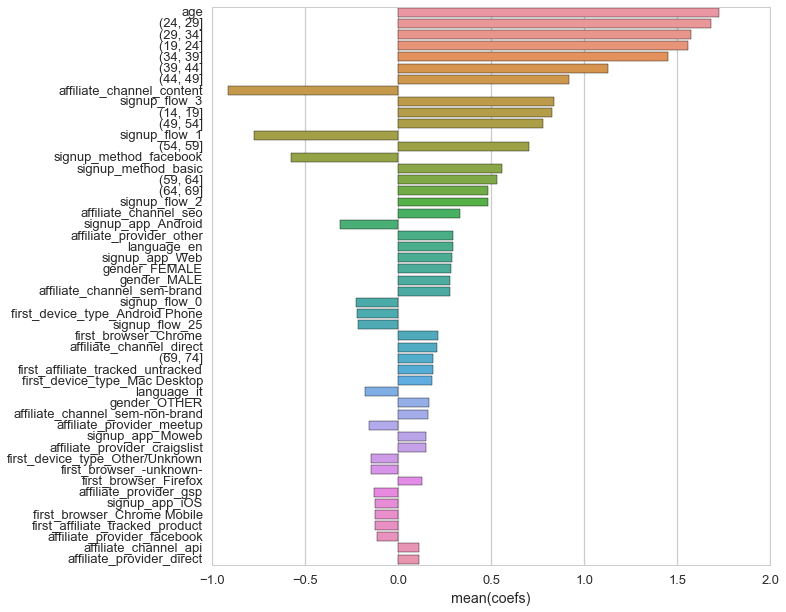

In [167]:
FeatureImportances = pd.DataFrame(data = { 'coefs': clf.coef_.squeeze(), 'abs coefs' : np.abs(clf.coef_.squeeze())},index=X_log.columns)
FeatureImportances.sort_values(by='abs coefs',ascending=False,inplace=True)

k = 50
plt.figure(figsize=(10,10))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances['coefs'].head(k))
#plt.xticks(rotation = 90)

The picture I get from this that people are less likely to book from mobile devices. And more likely to book if they correctly filled out their from. I doubt logicst regression has handled the age feature well. Hence why discretizing might be a good idea.

### Grid Search

In [164]:
Crange = np.logspace(-1,2,30)

grid = GridSearchCV(LogisticRegression(), param_grid={'C': Crange},scoring='accuracy',cv=3,n_jobs=4)
grid.fit(X_train,y_train)
print ("best parameter choice:", grid.best_params_)
print ("best score:", grid.best_score_)


best parameter choice: {'C': 4.5203536563602427}
best score: 0.688527559842


{'C': 11.937766417144358}

In [29]:
grid.best_score_

0.65801518849759433

# BELOW HERE IS MESSY - OLD CODE

In [171]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_int = le.fit_transform(y)
y_int

array([ 7,  7, 10, ...,  7,  7,  7], dtype=int64)

Feature ranking:
1. feature 7 (0.169181)
2. feature 6 (0.126675)
3. feature 3 (0.126461)
4. feature 0 (0.079587)
5. feature 5 (0.077573)
6. feature 2 (0.077413)
7. feature 1 (0.023134)
8. feature 4 (0.023095)
9. feature 158 (0.017394)
10. feature 103 (0.016936)
11. feature 104 (0.016154)
12. feature 157 (0.015355)
13. feature 152 (0.012130)
14. feature 153 (0.010904)
15. feature 159 (0.010050)
16. feature 41 (0.009514)
17. feature 35 (0.009106)
18. feature 50 (0.008587)
19. feature 59 (0.008130)
20. feature 160 (0.006609)
21. feature 97 (0.006535)
22. feature 100 (0.006261)
23. feature 38 (0.005960)
24. feature 83 (0.005943)
25. feature 161 (0.005407)
26. feature 156 (0.005146)
27. feature 138 (0.004599)
28. feature 13 (0.004376)
29. feature 24 (0.004372)
30. feature 135 (0.004321)
31. feature 162 (0.004196)
32. feature 63 (0.004164)
33. feature 111 (0.004075)
34. feature 14 (0.003888)
35. feature 42 (0.003530)
36. feature 163 (0.003471)
37. feature 40 (0.003186)
38. feature 10 (0.0031

ValueError: incompatible sizes: argument 'height' must be length 155 or scalar

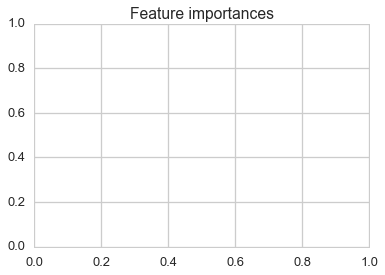

In [174]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=50,
                              random_state=0)



forest.fit(X_log, y_int)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_log.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_log.shape[1]), indices)
plt.xlim([-1, X_log.shape[1]])
plt.show()

Feature ranking:
1. feature 7 (0.169181)
2. feature 6 (0.126675)
3. feature 3 (0.126461)
4. feature 0 (0.079587)
5. feature 5 (0.077573)
6. feature 2 (0.077413)
7. feature 1 (0.023134)
8. feature 4 (0.023095)
9. feature 158 (0.017394)
10. feature 103 (0.016936)
11. feature 104 (0.016154)
12. feature 157 (0.015355)
13. feature 152 (0.012130)
14. feature 153 (0.010904)
15. feature 159 (0.010050)
16. feature 41 (0.009514)
17. feature 35 (0.009106)
18. feature 50 (0.008587)
19. feature 59 (0.008130)
20. feature 160 (0.006609)
21. feature 97 (0.006535)
22. feature 100 (0.006261)
23. feature 38 (0.005960)
24. feature 83 (0.005943)
25. feature 161 (0.005407)
26. feature 156 (0.005146)
27. feature 138 (0.004599)
28. feature 13 (0.004376)
29. feature 24 (0.004372)
30. feature 135 (0.004321)
31. feature 162 (0.004196)
32. feature 63 (0.004164)
33. feature 111 (0.004075)
34. feature 14 (0.003888)
35. feature 42 (0.003530)
36. feature 163 (0.003471)
37. feature 40 (0.003186)
38. feature 10 (0.0031

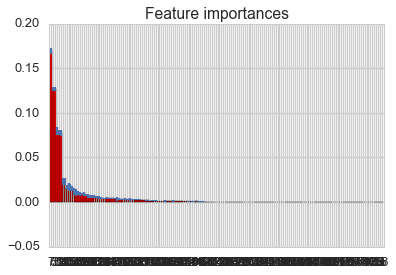

In [175]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_log.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_log.shape[1]), indices)
plt.xlim([-1, X_log.shape[1]])
plt.show()

In [176]:
X.columns[[7,6,3,0,5]]

Index(['tfa_hour', 'tfa_day', 'dac_day', 'age', 'tfa_month'], dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_int = le.fit_transform()
y_int

In [85]:
##Let's make this binary classification.
booked = y!='NDF'

In [87]:
#train_users = train_users[pd.to_datetime(train_users)]
X = preprocess_all(train_users.drop(['country_destination'],axis=1))
y = train_users['country_destination']

88908

In [168]:
## Let's get a classifier going
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X_log, y_log, random_state=0)

clf = RandomForestClassifier(n_estimators=25)
clf.fit(Xtrain,ytrain)
ypred = clf.predict(Xtest)


In [169]:
print('Accuracy = ',metrics.accuracy_score(ytest,ypred))
print('Recall = ',metrics.recall_score(ytest,ypred))
print('Precision = ',metrics.precision_score(ytest,ypred))

Accuracy =  0.661731911624
Recall =  0.578968829286
Precision =  0.593350977388


In [178]:
FeatureImportances = pd.Series(index=X_log.columns,data=clf.feature_importances_).sort_values(ascending=False)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


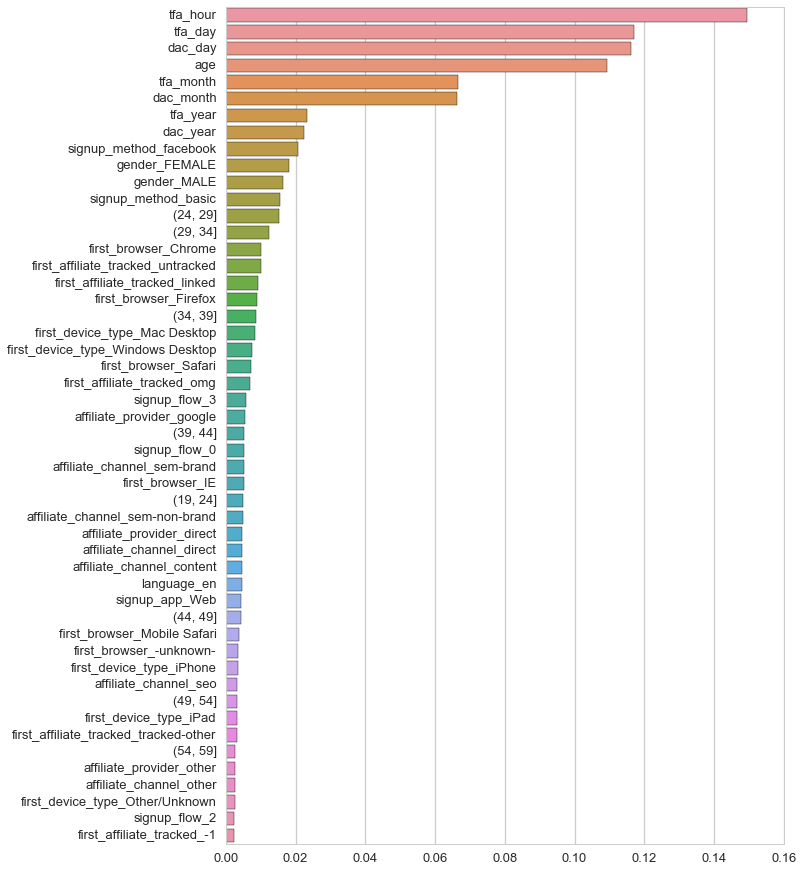

In [179]:
k = 50
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))
#plt.xticks(rotation = 90)

In [206]:
XX.reset_index()

,Booked,tfa_hour,country_destination,A
0,False,0,7294,7294
1,False,1,6718,6718
2,False,2,6371,6371
3,False,3,6585,6585
4,False,4,6988,6988
5,False,5,6661,6661
6,False,6,5613,5613
7,False,7,3912,3912
8,False,8,2361,2361
9,False,9,1504,1504


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


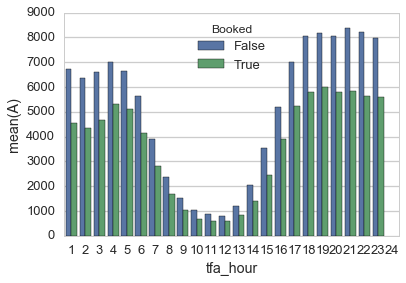

In [236]:
XX = pd.concat([X_log['tfa_hour'],y],axis=1)
XX['A'] = 1
XX['Booked'] = XX['country_destination']!='NDF'
XX = XX.groupby(['Booked','tfa_hour']).count()

sns.barplot(data=XX.reset_index(),x ='tfa_hour',y='A',hue='Booked', order = range(1,25))



In [254]:
YY

Booked,False,True,P
tfa_hour,,,
0,7294,4974,0.405445
1,6718,4564,0.404538
2,6371,4337,0.405024
3,6585,4651,0.413937
4,6988,5303,0.431454
5,6661,5122,0.434694
6,5613,4137,0.424308
7,3912,2809,0.417944
8,2361,1695,0.417899


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


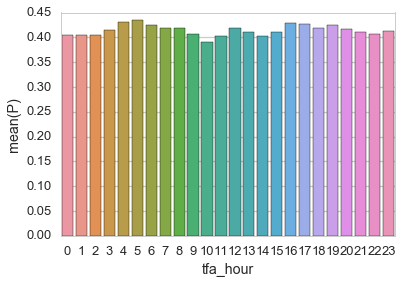

In [255]:
YY = XX['A'].unstack().T
YY.columns[1]
YY['P'] = YY[YY.columns[1]]/YY.sum(axis=1)
YY
sns.barplot(data=YY.reset_index(),x='tfa_hour',y='P')

In [225]:
YY = XX.unstack(level=0).drop('country_destination',axis=1)
YY.columns
#YY['proportion'] = YY[A,'True']/(YY[A,'True']+YY[A,'False'])

MultiIndex(levels=[['country_destination', 'A'], [False, True]],
           labels=[[1, 1], [0, 1]],
           names=[None, 'Booked'])